In [1]:
"""
2025-02-10 MY
Query PAITULI STAC to find out if there are daily NDVI mosaics. There was none.

NDVI Time-Series from Sentinel-2 Imagery Using STAC

Queryyn pitää olla joko BBOX tai Point, ei Polygon.

Kokeilin ensin tehdä yhdelle tiilelle NDVI:n, siitä olisin irroitellut polygoneja. 
Tiilen laskenta aikasarjalle (15 päivää) vei kaiken muistin, eikä riittänytkään.

Sitten kokeilin BBOX per pelto -> NDVI, sekin kesti liian kauan.

"""

import stackstac
from dask.distributed import Client, Lock
import pystac_client
import pyproj
import geopandas as gpd
import json
import requests
import os
import rioxarray
import re
import pandas as pd


import matplotlib.pyplot as plt

In [2]:
# Sentinel-2 tiles:
fp = '/scratch/project_2009889/sentinel2_tiles_world/suomiTiles.shp'
gdftiles = gpd.read_file(fp)
tile = '34VEM'
bbox = gdftiles[gdftiles['Name'] == tile].bounds.values[0] # minx, miny, maxx, maxy
gdftiles.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# demo data, tile wise:
tile = '34VEM'
fp = '/scratch/project_2006665/cropyield2023/forecasting/shpfiles/shpfiles_perTile/viljat-2023/parcels-2023_reprojected_3067_' + tile + '.shp'
gdf = gpd.read_file(fp)
gdf2 =gdf.to_crs(4326)
gdf3 = gdf2.head(2)
gdf3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
# pellot aluksi samassa projectiossa kuin tiili, mutta search tarvitsee epsg:4326

In [4]:
no_of_workers = len(os.sched_getaffinity(0))
client = Client(n_workers=no_of_workers)

In [5]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
#catalog

In [6]:
collection = catalog.get_collection('sentinel2-l2a')
#collection
# tarvitaan assets: B04_10m ja B08_10m ja cloud mask SCL_20m
print(f"ID: {collection.id}")
print(f"Title: {collection.title or 'N/A'}")
print(f"Description: {collection.description or 'N/A'}")

ID: sentinel2-l2a
Title: Sentinel-2 L2A
Description: Sentinel-2 products, processed to Level-2A (Surface Reflectance), a selection of mostly cloud-free products from Finland. More information: https://a3s.fi/sentinel-readme/README.txt


In [7]:
collection

id: sentinel2-l2a
title: Sentinel-2 L2A
"description: Sentinel-2 products, processed to Level-2A (Surface Reflectance), a selection of mostly cloud-free products from Finland. More information: https://a3s.fi/sentinel-readme/README.txt"
"providers: CSC Finland (host) ESA (producer, licensor) Maria Yli-Heikkilä (processor) Arttu Kivimäki (processor) Matias Heino (processor)"
crs: ['http://www.opengis.net/def/crs/OGC/1.3/CRS84']
type: Collection
id: S2A_MSIL2A_20240901T100031_N0511_R122_T34VDM_20240901T152250
"bbox: [19.182992688713956, 59.438616339812974, 21.177320731239504, 60.43645670712242]"
datetime: 2024-09-01T00:00:00.000+00:00
proj:epsg: 32634
eo:cloud_cover: 0


In [38]:
# esim. S2A_MSIL2A_20240901T100031_N0511_R122_T34VDM_20240901T152250

## Tiilikohtainen NDVI-laskenta

In [8]:
%%time

tile_box = catalog.search(
    bbox=[23.0,60.5,24.0,62.0],
    collections=["sentinel2-l2a"],
    datetime="2023-07-02"
)

items = tile_box.item_collection()

print('Found items: ' "{}".format(tile_box.matched()))
print('Items: ' "{}".format(len(items)))

Found items: 2
Items: 2
CPU times: user 9.95 ms, sys: 1.97 ms, total: 11.9 ms
Wall time: 273 ms


In [11]:
# ItemCollection as GeoJson 
stac_json = tile_box.item_collection_as_dict()

# Add Item ID to properties to have access to it in GeoPandas
for a in stac_json['features']:
    a['properties']['title']=a['id']

# GeoJson as GeoPandas dataframe
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
print('Found items: ' "{}".format(len(gdf))) 

Found items: 2


In [12]:
gdf

,geometry,datetime,proj:epsg,eo:cloud_cover,title
0,"POLYGON ((23.05056 60.33378, 23.05056 61.33444...",2023-07-02T00:00:00.000+00:00,32634,63,S2A_MSIL2A_20230702T100601_N0509_R022_T34VEN_2...
1,"POLYGON ((23.11116 61.23069, 23.11116 62.23177...",2023-07-02T00:00:00.000+00:00,32634,88,S2A_MSIL2A_20230702T100601_N0509_R022_T34VEP_2...


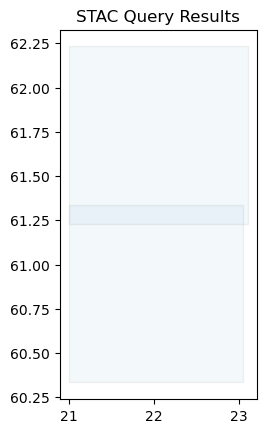

In [13]:
fig = gdf.plot(
    edgecolor="black",
    alpha=0.05,
)
_ = fig.set_title("STAC Query Results")

In [14]:
sentinel_stack = stackstac.stack(items, assets=["B04_10m", "B08_10m", "SCL_20m"],
                          #bounds=[point_lon-0.0005, point_lat-0.0005, point_lon+0.0005, point_lat+0.0005],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          ).to_dataset(dim='band')

In [45]:
sentinel_stack

<xarray.Dataset> Size: 11GB
Dimensions:              (time: 2, y: 20685, x: 10994, band: 3)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2023-07-02 2023-07-02
    id                   (time) <U60 480B 'S2A_MSIL2A_20230702T100601_N0509_R...
  * x                    (x) float64 88kB 5e+05 5e+05 ... 6.133e+05 6.133e+05
  * y                    (y) float64 165kB 6.902e+06 6.902e+06 ... 6.689e+06
    eo:cloud_cover       (time) int64 16B 63 88
    proj:epsg            int64 8B 32634
    gsd                  (band) int64 24B 10 10 20
    title                (band) <U7 84B 'B04_10m' 'B08_10m' 'SCL_20m'
    common_name          (band) object 24B 'red' 'nir' None
    center_wavelength    object 8B None
    full_width_half_max  object 8B None
    epsg                 int64 8B 32634
Dimensions without coordinates: band
Data variables:
    B04_10m              (time, y, x) float64 4GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08_10m              (time, y, x) float64 4GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 4GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32634, bounds=(499975.10568512854, 668857...
    crs:            epsg:32634
    transform:      | 10.31, 0.00, 499975.11|\n| 0.00,-10.31, 6901792.20|\n| ...
    resolution_xy:  (10.312379714232382, 10.307705467577534)

In [15]:
daily = sentinel_stack.resample(time="D").median("time", keep_attrs=True)
daily

<xarray.Dataset>
Dimensions:              (time: 1, y: 20685, x: 10994, band: 3)
Coordinates:
  * x                    (x) float64 5e+05 5e+05 5e+05 ... 6.133e+05 6.133e+05
  * y                    (y) float64 6.902e+06 6.902e+06 ... 6.689e+06 6.689e+06
    proj:epsg            int64 32634
    gsd                  (band) int64 10 10 20
    title                (band) <U7 'B04_10m' 'B08_10m' 'SCL_20m'
    common_name          (band) object 'red' 'nir' None
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32634
  * time                 (time) datetime64[ns] 2023-07-02
Dimensions without coordinates: band
Data variables:
    B04_10m              (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08_10m              (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32634, bounds=(499975.10568512854, 668857...
    crs:            epsg:32634
    transform:      | 10.31, 0.00, 499975.11|\n| 0.00,-10.31, 6901792.20|\n| ...
    resolution_xy:  (10.312379714232382, 10.307705467577534)

In [16]:
daily['ndvi'] = (daily['B08_10m'] - daily['B04_10m'])/\
                        (daily['B08_10m'] + daily['B04_10m'])
daily = daily[['ndvi', 'SCL_20m']]
#sentinel_stack = sentinel_stack.drop([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])
daily

<xarray.Dataset>
Dimensions:              (time: 1, y: 20685, x: 10994)
Coordinates:
  * x                    (x) float64 5e+05 5e+05 5e+05 ... 6.133e+05 6.133e+05
  * y                    (y) float64 6.902e+06 6.902e+06 ... 6.689e+06 6.689e+06
    proj:epsg            int64 32634
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 32634
  * time                 (time) datetime64[ns] 2023-07-02
Data variables:
    ndvi                 (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32634, bounds=(499975.10568512854, 668857...
    crs:            epsg:32634
    transform:      | 10.31, 0.00, 499975.11|\n| 0.00,-10.31, 6901792.20|\n| ...
    resolution_xy:  (10.312379714232382, 10.307705467577534)

In [17]:
os.getcwd()

'/projappl/project_2013001/agriNDVI/notebooks'

In [ ]:
%%time
output_file = os.path.join(os.getcwd(), "ndvi.tif")
mean_ndvi_tiff = daily.isel(time=0).rio.to_raster(
    output_file,
    lock=Lock(name="rio"),
    tiled=True,
)

<timed exec>:4: DeprecationWarning: The `client` parameter is deprecated. It is no longer necessary to pass a client to Lock.
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [30]:
%%time
# Up to this point, everything we did was lazy, only affecting metadata and task graphs. 
# Now we'll actually load our selected subset of data.
daily.compute() # kestii liian kauan ja ilmeisesti loppui muistikin

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.Dataset> Size: 4GB
Dimensions:              (time: 1, lat: 20685, lon: 10994)
Coordinates:
  * lon                  (lon) float64 88kB 5e+05 5e+05 ... 6.133e+05 6.133e+05
  * lat                  (lat) float64 165kB 6.902e+06 6.902e+06 ... 6.689e+06
    proj:epsg            int64 8B 32634
    center_wavelength    object 8B None
    full_width_half_max  object 8B None
    epsg                 int64 8B 32634
  * time                 (time) datetime64[ns] 8B 2023-07-02
Data variables:
    ndvi                 (time, lat, lon) float64 2GB nan nan nan ... nan nan
    SCL_20m              (time, lat, lon) float64 2GB nan nan nan ... nan nan
Attributes:
    spec:           RasterSpec(epsg=32634, bounds=(499975.10568512854, 668857...
    crs:            epsg:32634
    transform:      | 10.31, 0.00, 499975.11|\n| 0.00,-10.31, 6901792.20|\n| ...
    resolution_xy:  (10.312379714232382, 10.307705467577534)

## Uusi yritys: peltokohtainen NDVI-laskenta

In [ ]:
Nyt irrotetaan yksi pelto kerrallaan.

In [127]:
gdf3

,farmID,geometry
0,2023_16003171_710_1400,"POLYGON ((22.92883 59.96590, 22.93104 59.96634..."
1,2023_16002650_710_1400,"POLYGON ((22.95579 59.94535, 22.95582 59.94519..."


In [104]:
gdf3.__geo_interface__['features'][0]['bbox']

(22.92875407270216, 59.96227712434551, 22.935373242606595, 59.966628286757164)

In [121]:
results = []

for i in range(len(gdf3)):

    fieldbbox = gdf3.__geo_interface__['features'][i]['bbox']
    field = [gdf3.__geo_interface__['features'][i]['geometry']]

    tile_box = catalog.search(
        bbox=fieldbbox,
        collections=["sentinel2-l2a"],
        datetime="2023-07-01/2023-07-15"
    )

    items = tile_box.item_collection()

    print('Found items: ' "{}".format(tile_box.matched()))
    print('Items: ' "{}".format(len(items)))

    sentinel_stack = stackstac.stack(items, assets=["B04_10m", "B08_10m", "SCL_20m"],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                         epsg = 4326,
                          ).to_dataset(dim='band')   
    
    # Subset to polygon:
    sentinel_stack.rio.write_crs("epsg:4326", inplace=True)    
    subset = sentinel_stack.rio.clip(field, gdf3.crs)
    subset['ndvi'] = (subset['B08_10m'] - subset['B04_10m'])/\
                        (subset['B08_10m'] + subset['B04_10m'])
    subset2 = subset[['ndvi', 'SCL_20m']]
    
    # how to apply the cloud mask?
    
    subset3 = subset2.mean(dim=["x", "y"], skipna=True)
    break

    results.append(subset3)

Found items: 16
Items: 16


In [126]:
%%time
# Now we'll actually load our selected subset of data.
subset3.load()

KeyboardInterrupt: 

In [52]:
sentinel_stack

<xarray.Dataset>
Dimensions:              (time: 16, y: 11398, x: 20964, band: 3)
Coordinates: (12/13)
  * time                 (time) datetime64[ns] 2023-07-01 ... 2023-07-14
    id                   (time) <U60 'S2B_MSIL2A_20230701T094549_N0509_R079_T...
  * x                    (x) float64 21.0 21.0 21.0 21.0 ... 24.81 24.81 24.81
  * y                    (y) float64 60.44 60.44 60.44 60.44 ... 59.4 59.4 59.4
    proj:epsg            int64 32634
    eo:cloud_cover       (time) int64 80 69 74 32 33 83 83 ... 11 35 10 66 20 34
    ...                   ...
    gsd                  (band) int64 10 10 20
    common_name          (band) object 'red' 'nir' None
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 4326
    spatial_ref          int64 0
Dimensions without coordinates: band
Data variables:
    B04_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08_10m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(20.999485594468165, 59.3981...
    transform:      | 0.00, 0.00, 21.00|\n| 0.00,-0.00, 60.44|\n| 0.00, 0.00,...
    resolution_xy:  (0.00018161717270891387, 9.10993996788583e-05)

In [51]:
subset

<xarray.Dataset>
Dimensions:              (time: 16, x: 36, y: 47)
Coordinates:
  * time                 (time) datetime64[ns] 2023-07-01 ... 2023-07-14
    id                   (time) <U60 'S2B_MSIL2A_20230701T094549_N0509_R079_T...
  * x                    (x) float64 22.93 22.93 22.93 ... 22.93 22.94 22.94
  * y                    (y) float64 59.97 59.97 59.97 ... 59.96 59.96 59.96
    proj:epsg            int64 32634
    eo:cloud_cover       (time) int64 80 69 74 32 33 83 83 ... 11 35 10 66 20 34
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 4326
    spatial_ref          int64 0
Data variables:
    B04_10m              (time, y, x) float64 dask.array<chunksize=(1, 47, 36), meta=np.ndarray>
    B08_10m              (time, y, x) float64 dask.array<chunksize=(1, 47, 36), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 47, 36), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(20.999485594468165, 59.3981...
    transform:      | 0.00, 0.00, 21.00|\n| 0.00,-0.00, 60.44|\n| 0.00, 0.00,...
    resolution_xy:  (0.00018161717270891387, 9.10993996788583e-05)

In [129]:
subset2

<xarray.Dataset>
Dimensions:              (time: 16, y: 47, x: 36)
Coordinates:
  * time                 (time) datetime64[ns] 2023-07-01 ... 2023-07-14
    id                   (time) <U60 'S2B_MSIL2A_20230701T094549_N0509_R079_T...
  * x                    (x) float64 22.93 22.93 22.93 ... 22.93 22.94 22.94
  * y                    (y) float64 59.97 59.97 59.97 ... 59.96 59.96 59.96
    proj:epsg            int64 32634
    eo:cloud_cover       (time) int64 80 69 74 32 33 83 83 ... 11 35 10 66 20 34
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 4326
    spatial_ref          int64 0
Data variables:
    ndvi                 (time, y, x) float64 dask.array<chunksize=(1, 47, 36), meta=np.ndarray>
    SCL_20m              (time, y, x) float64 dask.array<chunksize=(1, 47, 36), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(20.999485594468165, 59.3981...
    transform:      | 0.00, 0.00, 21.00|\n| 0.00,-0.00, 60.44|\n| 0.00, 0.00,...
    resolution_xy:  (0.00018161717270891387, 9.10993996788583e-05)

In [120]:
subset3

<xarray.Dataset>
Dimensions:              (time: 16)
Coordinates:
  * time                 (time) datetime64[ns] 2023-07-01 ... 2023-07-14
    id                   (time) <U60 'S2B_MSIL2A_20230701T094549_N0509_R079_T...
    proj:epsg            int64 32634
    eo:cloud_cover       (time) int64 80 69 74 32 33 83 83 ... 11 35 10 66 20 34
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 4326
    spatial_ref          int64 0
Data variables:
    ndvi                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SCL_20m              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [130]:
# Promote non-dimensional coordinates to dimensions
#ds = ds.assign_coords(dict(Day=timestamps, 
#                           Stats=['mean','std','median','25%','75%'], # From documentation 
#                          ))